In [1]:
import os
os.environ["OMP_NUM_THREADS"] = "1" # export OMP_NUM_THREADS=1
os.environ["OPENBLAS_NUM_THREADS"] = "1" # export OPENBLAS_NUM_THREADS=1
os.environ["MKL_NUM_THREADS"] = "1" # export MKL_NUM_THREADS=1
os.environ["VECLIB_MAXIMUM_THREADS"] = "1" # export VECLIB_MAXIMUM_THREADS=1
os.environ["NUMEXPR_NUM_THREADS"] = "1" # export NUMEXPR_NUM_THREADS=1
os.environ["CUDA_VISIBLE_DEVICES"]="1"

import numpy as np
import matplotlib.pyplot as plt
import multielec_src.fitting as fitting
import multielec_src.multielec_utils as mutils
from scipy.io import loadmat
import multiprocessing as mp
import statsmodels.api as sm
from copy import deepcopy, copy
import visionloader as vl

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
def sample_spikes(p_true, t):
    p_true, t = np.array(p_true), np.array(t).astype(int)
    
    p_empirical = []
    for i in range(len(p_true)):
        if t[i] == 0:
            p_empirical += [0.5]
        
        else:
            p_empirical += [np.mean(np.random.choice(np.array([0, 1]), 
                                                 p=np.array([1-p_true[i], p_true[i]]), 
                                                 size=t[i]))]
        
    p_empirical_array = np.array(p_empirical)

    return p_empirical_array

In [3]:
def sample_spikes_array(true_probs, trials, NUM_THREADS=24):

    input_list = []
    for i in range(len(true_probs)):
        for j in range(len(true_probs[i])):
            input_list += [(true_probs[i][j], trials[j])]
            
    pool = mp.Pool(processes=NUM_THREADS)
    results = pool.starmap_async(sample_spikes, input_list)
    mp_output = results.get()
    pool.close()

    return np.array(mp_output).reshape(true_probs.shape)
    

In [4]:
def get_performance_array(true_params, curr_probs, true_probs):
    
    error = 0
    cnt = 0
    for i in range(len(true_params)):
        for j in range(len(true_params[i])):
            if ~np.all(true_params[i][j][:, 0] == -np.inf):
                error += np.sqrt(np.sum((curr_probs[i][j] - true_probs[i][j])**2) / len(true_probs[i][j]))
                cnt += 1

    return error / cnt

# Old labview

In [5]:
Ivals = np.array([0.10053543, 0.11310236, 0.11938583, 0.13195276, 0.14451969,                        
                       0.16337008, 0.17593701, 0.1947874 , 0.2136378 , 0.23877165,
                       0.25762205, 0.2780315 , 0.30330709, 0.35385827, 0.37913386,
                       0.42968504, 0.45496063, 0.50551181, 0.55606299, 0.60661417,
                       0.68244094, 0.73299213, 0.8088189 , 0.88464567, 0.98574803,
                       1.10433071, 1.20472441, 1.30511811, 1.40551181, 1.60629921,
                       1.70669291, 1.90748031, 2.10826772, 2.30905512, 2.50984252,
                       2.81102362, 3.11220472, 3.41338583, 3.71456693, 4.1161])

In [6]:
GSORT_BASE = "/Volumes/Scratch/Analysis"
ANALYSIS_BASE = "/Volumes/Analysis"
dataset = "2020-10-18-5"
wnoise = "kilosort_data002/data002"
blanked_probs = 12
prob_high = 0.8
prob_low = 0.2
min_inds = 2

estim_neg = "data001"

outpath = os.path.join(GSORT_BASE, dataset, estim_neg, wnoise)
electrical_path = os.path.join(ANALYSIS_BASE, dataset, estim_neg)
parameters = loadmat(os.path.join(outpath, 'parameters.mat'))

cells = parameters['cells'].flatten()
num_cells = len(cells)
num_patterns = max(parameters['patterns'].flatten())
num_movies = parameters['movies'].flatten()[0]

all_probs_neg = np.array(np.memmap(os.path.join(outpath, 'init_probs.dat'),mode='r',shape=(num_cells, num_patterns, num_movies), dtype='float32'))
trials_neg = np.array(np.memmap(os.path.join(outpath, 'trial.dat'),mode='r',shape=(num_patterns, num_movies), dtype='int16'), dtype=int)
amps_neg = np.array([-Ivals.reshape(-1, 1)] * len(trials_neg))

# Processing data below: do other stuff if your pipeline is different
all_probs_neg[:, :, :blanked_probs] = 0

clean_inds_array = np.full((all_probs_neg.shape[0], all_probs_neg.shape[1]), 
                            None, dtype=object)

for i in range(len(all_probs_neg)):
    for j in range(len(all_probs_neg[i])):
        if np.count_nonzero((all_probs_neg[i][j] >= prob_low) & (all_probs_neg[i][j] <= prob_high)) >= min_inds:
            print(cells[i], j+1)

            clean_inds = np.where(~np.isnan(all_probs_neg[i][j]))[0]
            clean_inds_array[i][j] = clean_inds

            all_probs_neg[i][j][clean_inds] = fitting.disambiguate_sigmoid(all_probs_neg[i][j][clean_inds], spont_limit=prob_low, noise_limit=0.1)

            # all_probs_neg[i][j][clean_inds] = fitting.disambiguate_fitting(amps_neg[j][clean_inds], 
            #                                 all_probs_neg[i][j][clean_inds],
            #                                 trials_neg[j][clean_inds], [1], 
            #                                 prob_high=prob_high, prob_low=prob_low)

5 13
16 27
16 35
16 36
16 44
16 45
16 46
16 62
17 14
17 22
17 31
17 40
17 431
27 52
31 75
32 51
42 56
42 61
42 65
42 69
42 74
42 83
42 92
44 61
44 65
44 69
52 76
52 93
55 100
57 82
57 88
57 91
57 97
57 100
116 109
116 114
116 118
116 119
116 123
116 126
116 129
120 114
120 119
120 126
126 133
131 142
131 143
131 144
132 128
132 145
134 147
134 148
134 154
144 165
144 174
144 175
144 185
154 190
154 318
168 208
168 217
168 218
168 226
168 227
168 228
171 225
171 235
177 203
177 234
177 309
177 359
177 367
177 373
177 391
177 394
203 250
203 251
203 252
204 254
216 268
216 277
216 283
216 286
216 295
216 339
216 379
220 262
220 263
220 266
220 270
220 275
220 278
220 279
220 284
220 288
220 293
221 271
221 280
221 289
222 273
268 280
268 289
299 295
319 292
319 301
319 327
319 337
319 358
319 364
319 371
319 372
364 334
410 337
410 349
410 350
410 358
410 359
410 367
410 368
410 375
410 376
410 382
414 343
414 347
414 352
414 356
414 361
415 361
434 354
434 355
434 363
434 364
434 367
43

In [37]:
ms = [1]

w_inits_array = np.zeros((all_probs_neg.shape[0], all_probs_neg.shape[1]), dtype=object)
for i in range(len(w_inits_array)):
    for j in range(len(w_inits_array[i])):
        w_inits = []

        for m in ms:
            w_init = np.array(np.random.normal(size=(m, amps_neg[j].shape[1]+1)))
            w_inits.append(w_init)

        w_inits_array[i][j] = w_inits

In [38]:
input_list = fitting.generate_input_list(all_probs_neg, amps_neg, trials_neg, w_inits_array, prob_low,
                                         pass_inds=clean_inds_array)

pool = mp.Pool(processes=24)
results = pool.starmap_async(fitting.fit_surface, input_list)
mp_output = results.get()
pool.close()

In [39]:
params_true = np.zeros((all_probs_neg.shape[0], all_probs_neg.shape[1]), dtype=object)
inits = np.zeros((all_probs_neg.shape[0], all_probs_neg.shape[1]), dtype=object)
R2s = np.zeros((all_probs_neg.shape[0], all_probs_neg.shape[1]))
probs_true = np.zeros(all_probs_neg.shape)

cnt = 0
for i in range(len(all_probs_neg)):
    for j in range(len(all_probs_neg[i])):
        params_true[i][j] = mp_output[cnt][0]
        inits[i][j] = mp_output[cnt][1]
        R2s[i][j] = mp_output[cnt][2]
        
        probs_true[i][j] = fitting.sigmoidND_nonlinear(
                                sm.add_constant(amps_neg[j], has_constant='add'), 
                                params_true[i][j])
        

        cnt += 1

In [ ]:
# CHECK DATASET IF NEEDED

for i in range(len(all_probs_neg)):
    for j in range(len(all_probs_neg[i])):
        if ~np.all(params_true[i][j][:, 0] == -np.inf):

            print(params_true[i][j], R2s[i][j])
            
            plt.figure(0)
            plt.xlim(-4.2, 0.1)
            plt.ylim(-0.1, 1.1)
            plt.scatter(amps_neg[j].flatten(), all_probs_neg[i][j])
            plt.plot(amps_neg[j].flatten(), probs_true[i][j])
            plt.show()
            input()

In [40]:
EI_cutoff = 0

vstim_datapath = os.path.join(ANALYSIS_BASE, dataset, wnoise)
vstim_datarun = wnoise[-7:]
vcd = vl.load_vision_data(vstim_datapath, vstim_datarun,
                          include_neurons=True,
                          include_ei=True,
                          include_params=True,
                          include_noise=True)

above_thr_inds = []
for n in vcd.get_cell_ids():
    cell_type = vcd.get_cell_type_for_cell(n).lower()
    if 'parasol' in cell_type or 'midget' in cell_type:
        _, EI = mutils.get_collapsed_ei_thr(vcd, n, 0)
        above_thr = np.where(EI > EI_cutoff)[0]
        if len(above_thr) > 0:
            above_thr_inds.append(above_thr)

above_thr_all = np.unique(np.concatenate(above_thr_inds))
bad_inds = np.setdiff1d(np.arange(len(trials_neg), dtype=int), above_thr_all).astype(int)

Setting up data...
Fitting dataset...
Calculating Jacobian...
Optimizing trials...
0
(DeviceArray(23162.236, dtype=float32), DeviceArray(2910.084, dtype=float32), DeviceArray(1140272.2, dtype=float32), DeviceArray(1117110., dtype=float32))
1
(DeviceArray(24236.361, dtype=float32), DeviceArray(2762.4019, dtype=float32), DeviceArray(944495.94, dtype=float32), DeviceArray(920259.56, dtype=float32))
2
(DeviceArray(38866.285, dtype=float32), DeviceArray(2288.0562, dtype=float32), DeviceArray(326854.72, dtype=float32), DeviceArray(287988.44, dtype=float32))
3
(DeviceArray(2093093.9, dtype=float32), DeviceArray(1708.8351, dtype=float32), DeviceArray(2577168.5, dtype=float32), DeviceArray(484074.6, dtype=float32))
4
(DeviceArray(52837.21, dtype=float32), DeviceArray(2293.8022, dtype=float32), DeviceArray(348484.8, dtype=float32), DeviceArray(295647.6, dtype=float32))
5
(DeviceArray(25151.17, dtype=float32), DeviceArray(2533.5608, dtype=float32), DeviceArray(640380.9, dtype=float32), DeviceArra

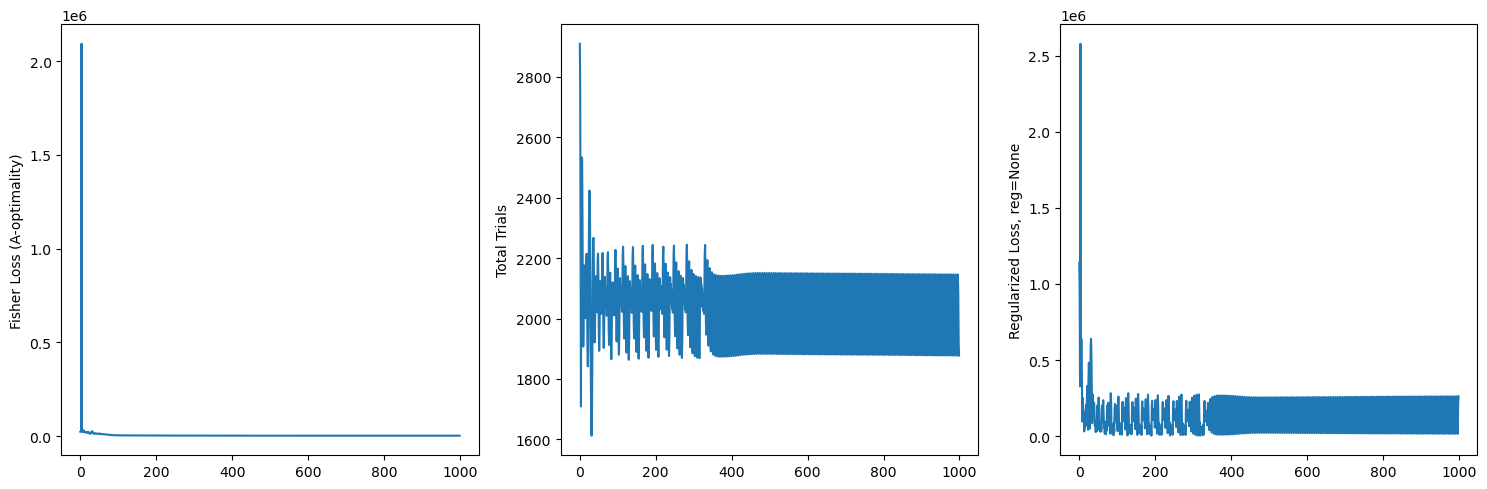

0.08240719073427928 0.08240719073427928


/tmp/ipykernel_54851/725565986.py:107: RuntimeWarning: invalid value encountered in true_divide
  p_tmp = (p_new * T_new[np.newaxis, :, :] + probs_empirical * T_prev[np.newaxis, :, :]) / ((T_new + T_prev)[np.newaxis, :, :])
/tmp/ipykernel_54851/725565986.py:125: RuntimeWarning: invalid value encountered in true_divide
  p_tmp_uniform = (p_new_uniform * T_new_uniform[np.newaxis, :, :] + probs_empirical_uniform * T_prev_uniform[np.newaxis, :, :]) / ((T_prev_uniform + T_new_uniform)[np.newaxis, :, :])


Setting up data...
Fitting dataset...
Calculating Jacobian...
Optimizing trials...
0
(DeviceArray(20009.227, dtype=float32), DeviceArray(2911.5842, dtype=float32), DeviceArray(22087.309, dtype=float32), DeviceArray(2078.083, dtype=float32))
1
(DeviceArray(12193.89, dtype=float32), DeviceArray(2764.5168, dtype=float32), DeviceArray(13907.961, dtype=float32), DeviceArray(1714.0715, dtype=float32))
2
(DeviceArray(15211.6875, dtype=float32), DeviceArray(2290.12, dtype=float32), DeviceArray(15751.563, dtype=float32), DeviceArray(539.8764, dtype=float32))
3
(DeviceArray(44300.383, dtype=float32), DeviceArray(1711.4805, dtype=float32), DeviceArray(45192.715, dtype=float32), DeviceArray(892.3339, dtype=float32))
4
(DeviceArray(9970.658, dtype=float32), DeviceArray(2297.9932, dtype=float32), DeviceArray(10530.021, dtype=float32), DeviceArray(559.3632, dtype=float32))
5
(DeviceArray(8432.845, dtype=float32), DeviceArray(2538.959, dtype=float32), DeviceArray(9588.631, dtype=float32), DeviceArray(

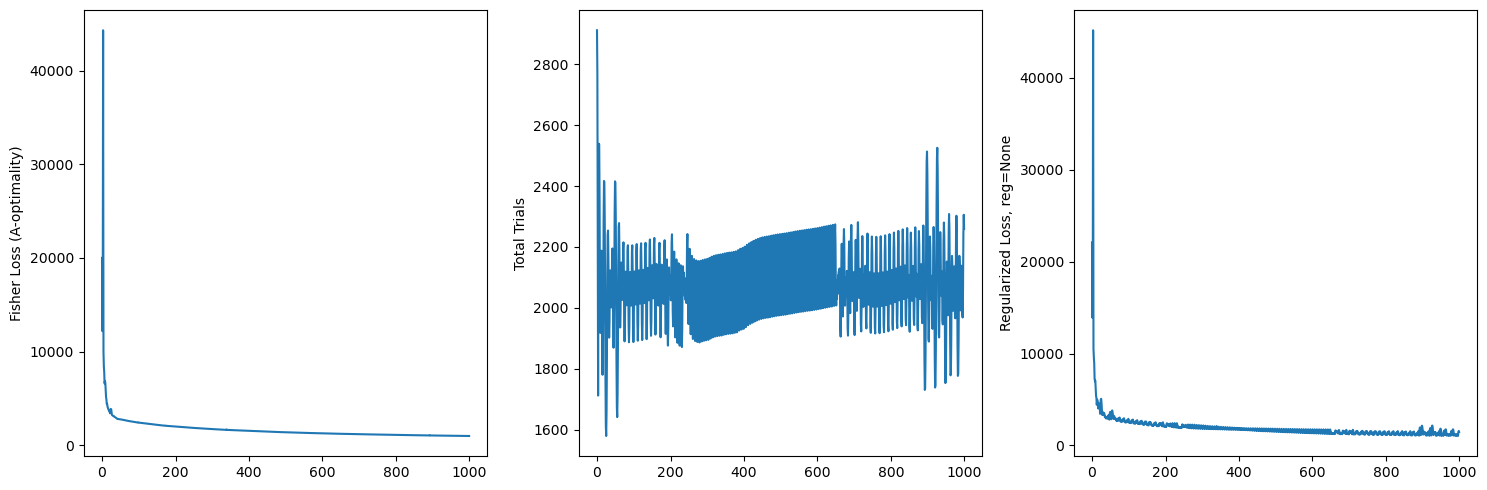

0.05561410720688074 0.0787109651982878


/tmp/ipykernel_54851/725565986.py:107: RuntimeWarning: invalid value encountered in true_divide
  p_tmp = (p_new * T_new[np.newaxis, :, :] + probs_empirical * T_prev[np.newaxis, :, :]) / ((T_new + T_prev)[np.newaxis, :, :])
/tmp/ipykernel_54851/725565986.py:125: RuntimeWarning: invalid value encountered in true_divide
  p_tmp_uniform = (p_new_uniform * T_new_uniform[np.newaxis, :, :] + probs_empirical_uniform * T_prev_uniform[np.newaxis, :, :]) / ((T_prev_uniform + T_new_uniform)[np.newaxis, :, :])


Setting up data...
Fitting dataset...
Calculating Jacobian...
Optimizing trials...
0
(DeviceArray(3391.3423, dtype=float32), DeviceArray(2910.1843, dtype=float32), DeviceArray(3978.2202, dtype=float32), DeviceArray(586.8779, dtype=float32))
1
(DeviceArray(2879.467, dtype=float32), DeviceArray(2762.158, dtype=float32), DeviceArray(3362.7002, dtype=float32), DeviceArray(483.2332, dtype=float32))
2
(DeviceArray(2075.8054, dtype=float32), DeviceArray(2286.8098, dtype=float32), DeviceArray(2226.2104, dtype=float32), DeviceArray(150.40503, dtype=float32))
3
(DeviceArray(1832.5781, dtype=float32), DeviceArray(1706.55, dtype=float32), DeviceArray(2088.458, dtype=float32), DeviceArray(255.8799, dtype=float32))
4
(DeviceArray(1745.5309, dtype=float32), DeviceArray(2292.7314, dtype=float32), DeviceArray(1900.0822, dtype=float32), DeviceArray(154.55122, dtype=float32))
5
(DeviceArray(1646.0438, dtype=float32), DeviceArray(2533.18, dtype=float32), DeviceArray(1968.9517, dtype=float32), DeviceArray(

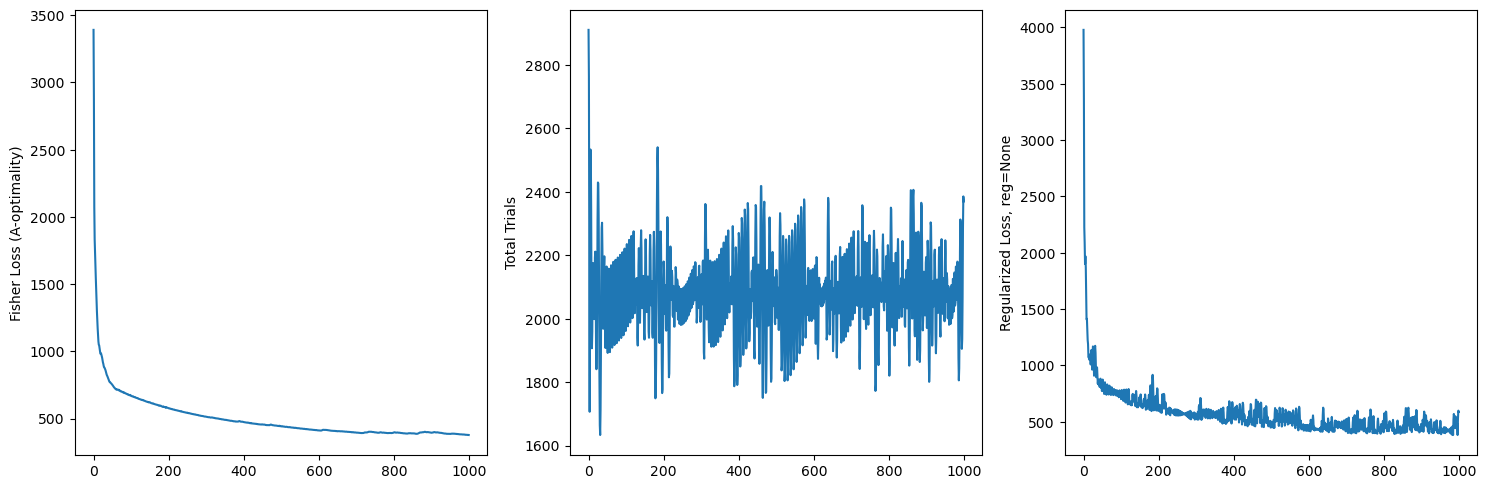

0.03981509574645237 0.06693691000525345


/tmp/ipykernel_54851/725565986.py:107: RuntimeWarning: invalid value encountered in true_divide
  p_tmp = (p_new * T_new[np.newaxis, :, :] + probs_empirical * T_prev[np.newaxis, :, :]) / ((T_new + T_prev)[np.newaxis, :, :])
/tmp/ipykernel_54851/725565986.py:125: RuntimeWarning: invalid value encountered in true_divide
  p_tmp_uniform = (p_new_uniform * T_new_uniform[np.newaxis, :, :] + probs_empirical_uniform * T_prev_uniform[np.newaxis, :, :]) / ((T_prev_uniform + T_new_uniform)[np.newaxis, :, :])


Setting up data...
Fitting dataset...
Calculating Jacobian...
Optimizing trials...
0
(DeviceArray(647.8961, dtype=float32), DeviceArray(2911.1836, dtype=float32), DeviceArray(675.78925, dtype=float32), DeviceArray(27.89314, dtype=float32))
1
(DeviceArray(631.94507, dtype=float32), DeviceArray(2764.0005, dtype=float32), DeviceArray(654.94604, dtype=float32), DeviceArray(23.001007, dtype=float32))
2
(DeviceArray(616.88763, dtype=float32), DeviceArray(2289.245, dtype=float32), DeviceArray(624.1085, dtype=float32), DeviceArray(7.2208858, dtype=float32))
3
(DeviceArray(602.6418, dtype=float32), DeviceArray(1709.5065, dtype=float32), DeviceArray(614.6905, dtype=float32), DeviceArray(12.048715, dtype=float32))
4
(DeviceArray(589.175, dtype=float32), DeviceArray(2296.4858, dtype=float32), DeviceArray(596.63654, dtype=float32), DeviceArray(7.461556, dtype=float32))
5
(DeviceArray(576.4018, dtype=float32), DeviceArray(2537.3154, dtype=float32), DeviceArray(591.86816, dtype=float32), DeviceArray(

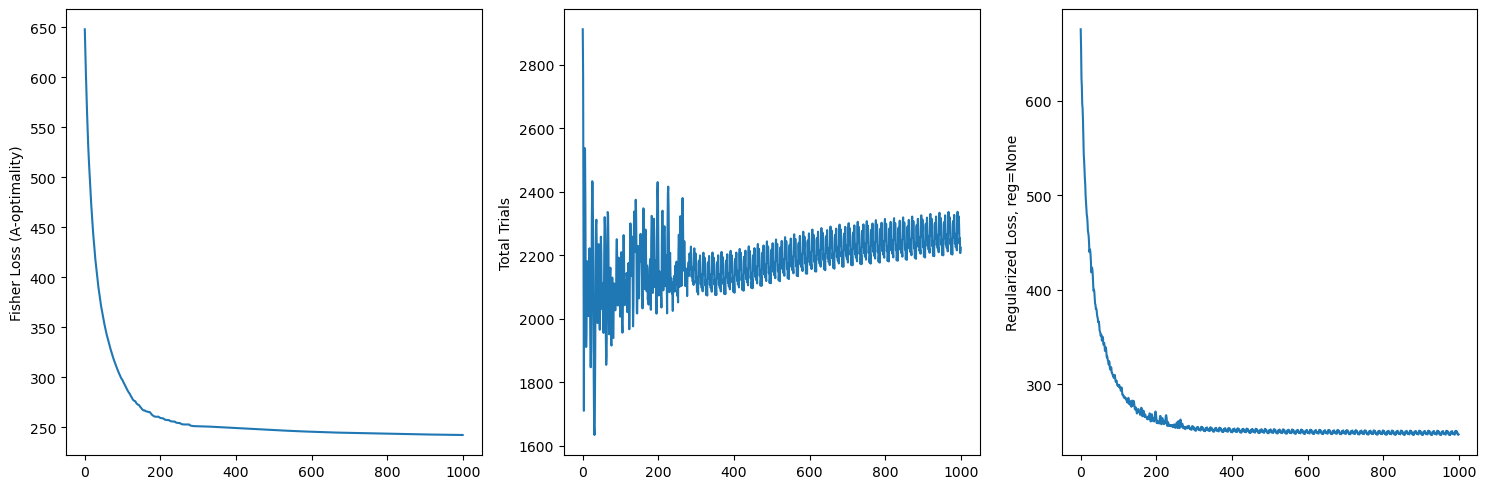

0.03296544663655539 0.059287808061401964


/tmp/ipykernel_54851/725565986.py:107: RuntimeWarning: invalid value encountered in true_divide
  p_tmp = (p_new * T_new[np.newaxis, :, :] + probs_empirical * T_prev[np.newaxis, :, :]) / ((T_new + T_prev)[np.newaxis, :, :])
/tmp/ipykernel_54851/725565986.py:125: RuntimeWarning: invalid value encountered in true_divide
  p_tmp_uniform = (p_new_uniform * T_new_uniform[np.newaxis, :, :] + probs_empirical_uniform * T_prev_uniform[np.newaxis, :, :]) / ((T_prev_uniform + T_new_uniform)[np.newaxis, :, :])


Setting up data...
Fitting dataset...
Calculating Jacobian...
Optimizing trials...
0
(DeviceArray(986.26526, dtype=float32), DeviceArray(2910.884, dtype=float32), DeviceArray(1030.5941, dtype=float32), DeviceArray(44.32884, dtype=float32))
1
(DeviceArray(925.5604, dtype=float32), DeviceArray(2764.635, dtype=float32), DeviceArray(962.1611, dtype=float32), DeviceArray(36.600655, dtype=float32))
2
(DeviceArray(872.9828, dtype=float32), DeviceArray(2291.2544, dtype=float32), DeviceArray(884.5688, dtype=float32), DeviceArray(11.5859785, dtype=float32))
3
(DeviceArray(827.11865, dtype=float32), DeviceArray(1713.1381, dtype=float32), DeviceArray(846.08185, dtype=float32), DeviceArray(18.963207, dtype=float32))
4
(DeviceArray(786.8305, dtype=float32), DeviceArray(2300.186, dtype=float32), DeviceArray(798.8884, dtype=float32), DeviceArray(12.05795, dtype=float32))
5
(DeviceArray(751.27026, dtype=float32), DeviceArray(2541.4678, dtype=float32), DeviceArray(776.0782, dtype=float32), DeviceArray(2

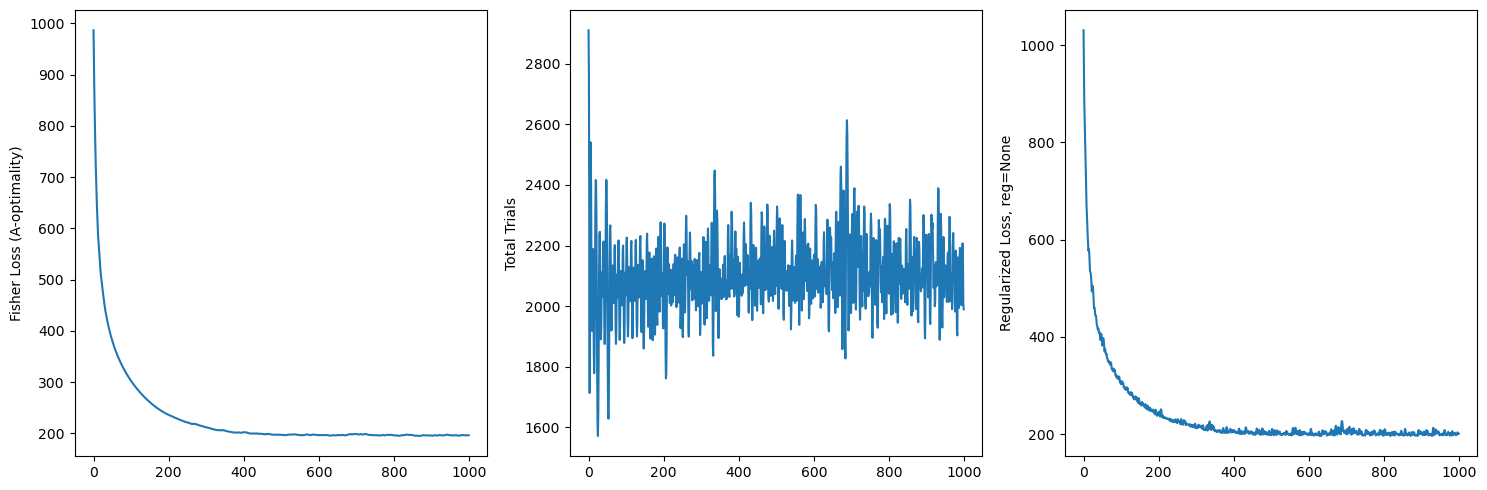

0.02732094078159098 0.05414582905795209


/tmp/ipykernel_54851/725565986.py:107: RuntimeWarning: invalid value encountered in true_divide
  p_tmp = (p_new * T_new[np.newaxis, :, :] + probs_empirical * T_prev[np.newaxis, :, :]) / ((T_new + T_prev)[np.newaxis, :, :])
/tmp/ipykernel_54851/725565986.py:125: RuntimeWarning: invalid value encountered in true_divide
  p_tmp_uniform = (p_new_uniform * T_new_uniform[np.newaxis, :, :] + probs_empirical_uniform * T_prev_uniform[np.newaxis, :, :]) / ((T_prev_uniform + T_new_uniform)[np.newaxis, :, :])


Setting up data...
Fitting dataset...
Calculating Jacobian...
Optimizing trials...
0
(DeviceArray(543.81647, dtype=float32), DeviceArray(2911.8838, dtype=float32), DeviceArray(567.6201, dtype=float32), DeviceArray(23.803627, dtype=float32))
1
(DeviceArray(522.9825, dtype=float32), DeviceArray(2766.552, dtype=float32), DeviceArray(542.6672, dtype=float32), DeviceArray(19.684696, dtype=float32))
2
(DeviceArray(504.0271, dtype=float32), DeviceArray(2294.0217, dtype=float32), DeviceArray(510.31955, dtype=float32), DeviceArray(6.292445, dtype=float32))
3
(DeviceArray(486.786, dtype=float32), DeviceArray(1716.6124, dtype=float32), DeviceArray(496.85825, dtype=float32), DeviceArray(10.072243, dtype=float32))
4
(DeviceArray(471.02008, dtype=float32), DeviceArray(2304.4336, dtype=float32), DeviceArray(477.6076, dtype=float32), DeviceArray(6.5875335, dtype=float32))
5
(DeviceArray(456.5963, dtype=float32), DeviceArray(2546.5107, dtype=float32), DeviceArray(470.0447, dtype=float32), DeviceArray(1

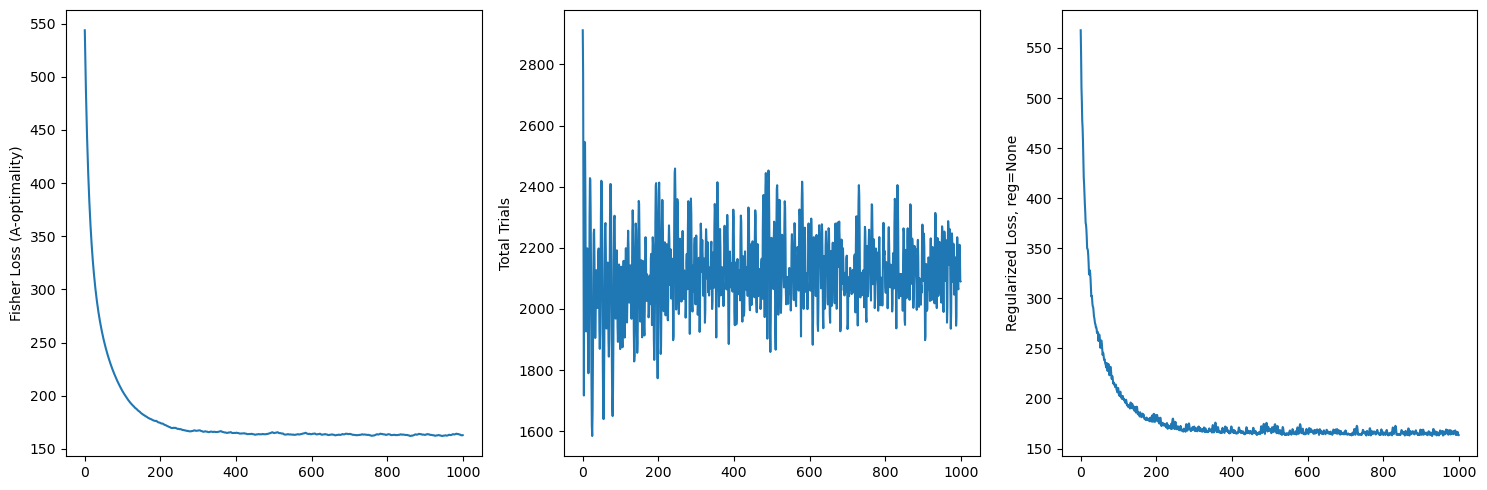

0.023862287100372873 0.05053506650773124


In [41]:
# total_budget = 20000
num_iters = 5

T_prev = np.zeros_like(trials_neg, dtype=float)
budget = T_prev.shape[0] * T_prev.shape[1] * 0.1    #int(total_budget / num_iters)
reg = None # 20, 50
T_step_size = 0.05 # 0.05, 0.01
T_n_steps = 1000    # 5000

init_trials = 20
ms = [1]
disambiguate = True
verbose = True
R2_cutoff = 0
prob_low = 0.05

T_prev[:, 0] = init_trials
T_prev[:, T_prev.shape[1]-1] = init_trials
T_prev[:, 31] = init_trials
# T_prev[:, ::3] = init_trials
# T_prev[bad_inds, :] = 0
T_prev_uniform = deepcopy(T_prev)

probs_empirical = sample_spikes_array(probs_true, T_prev, NUM_THREADS=24)
probs_empirical_uniform = deepcopy(probs_empirical)

performances = []
performances_uniform = []
num_samples = []
num_samples_uniform = []

iter_cnt = 0
while True:
    if iter_cnt == 0:
        T_new, w_inits_array, t_final, probs_curr, params_curr = fitting.fisher_sampling_1elec(
                                        probs_empirical, 
                                        T_prev, amps_neg,
                                        T_step_size=T_step_size,
                                        T_n_steps=T_n_steps,
                                        verbose=verbose, budget=budget, ms=ms, reg=reg,
                                        return_probs=True,
                                        disambiguate=disambiguate,
                                        R2_cutoff=R2_cutoff,
                                        min_prob=prob_low)

        performance = get_performance_array(params_true, probs_curr, probs_true)
        performance_uniform = performance

        w_inits_array_uniform = deepcopy(w_inits_array)
        
    else:
        T_new, w_inits_array, t_final, probs_curr, params_curr = fitting.fisher_sampling_1elec(
                                        probs_empirical, 
                                        T_prev, amps_neg,
                                        T_step_size=T_step_size,
                                        T_n_steps=T_n_steps,
                                        verbose=verbose, budget=budget, ms=ms, reg=reg,
                                        return_probs=True,
                                        # t_final=t_final,
                                        w_inits_array=w_inits_array,
                                        disambiguate=disambiguate,
                                        R2_cutoff=R2_cutoff,
                                        min_prob=prob_low)
        
        performance = get_performance_array(params_true, probs_curr, probs_true)

        input_list_uniform = fitting.generate_input_list(probs_empirical_uniform, amps_neg, T_prev_uniform, w_inits_array_uniform, prob_low,
                                                            disambiguate=disambiguate)

        pool = mp.Pool(processes=24)
        results_uniform = pool.starmap_async(fitting.fit_surface, input_list_uniform)
        mp_output_uniform = results_uniform.get()
        pool.close()

        params_curr_uniform = np.zeros((probs_empirical_uniform.shape[0], probs_empirical_uniform.shape[1]), dtype=object)
        w_inits_array_uniform = np.zeros((probs_empirical_uniform.shape[0], probs_empirical_uniform.shape[1]), dtype=object)
        probs_curr_uniform = np.zeros(probs_empirical_uniform.shape)

        cnt = 0
        for i in range(len(probs_empirical_uniform)):
            for j in range(len(probs_empirical_uniform[i])):
                params_curr_uniform[i][j] = mp_output_uniform[cnt][0]
                w_inits_array_uniform[i][j] = mp_output_uniform[cnt][1]
                
                probs_curr_uniform[i][j] = fitting.sigmoidND_nonlinear(
                                        sm.add_constant(amps_neg[j], has_constant='add'), 
                                        params_curr_uniform[i][j])

                cnt += 1

        performance_uniform = get_performance_array(params_true, probs_curr_uniform, probs_true)
    
    print(performance, performance_uniform)
    
    performances.append(performance)
    performances_uniform.append(performance_uniform)
    
    num_samples.append(np.sum(T_prev))
    num_samples_uniform.append(np.sum(T_prev_uniform))

    iter_cnt += 1

    if iter_cnt > num_iters:
        break

    p_new = sample_spikes_array(probs_true, T_new, NUM_THREADS=24)
    p_tmp = (p_new * T_new[np.newaxis, :, :] + probs_empirical * T_prev[np.newaxis, :, :]) / ((T_new + T_prev)[np.newaxis, :, :])
    T_tmp = T_new + T_prev

    p_tmp = np.nan_to_num(p_tmp, nan=0.5)

    probs_empirical = p_tmp
    T_prev = T_tmp
    
    T_smart = np.zeros_like(T_new[above_thr_all, 12:], dtype=float)
    random_extra = np.random.choice(len(T_smart.flatten()), size=int(np.sum(T_new)), replace=True)
    T_smart_uniform = np.array(np.bincount(random_extra, minlength=len(T_smart.flatten())).astype(int).reshape(T_smart.shape), dtype=float)
    T_new_uniform = np.zeros_like(T_new, dtype=float)
    T_new_uniform[above_thr_all, 12:] = T_smart_uniform
    # T_new_uniform = np.ones_like(T_prev_uniform, dtype=float)
    # T_new_uniform[:, :12] = 0
    # T_new_uniform[bad_inds, :] = 0
    p_new_uniform = sample_spikes_array(probs_true, T_new_uniform, NUM_THREADS=24)

    p_tmp_uniform = (p_new_uniform * T_new_uniform[np.newaxis, :, :] + probs_empirical_uniform * T_prev_uniform[np.newaxis, :, :]) / ((T_prev_uniform + T_new_uniform)[np.newaxis, :, :])
    T_tmp_uniform = T_prev_uniform + T_new_uniform

    p_tmp_uniform = np.nan_to_num(p_tmp_uniform, nan=0.5)

    probs_empirical_uniform = p_tmp_uniform
    T_prev_uniform = T_tmp_uniform

In [42]:
baseline_trials = 20
T_prev_baseline = np.ones_like(trials_neg, dtype=float) * baseline_trials

probs_empirical_baseline = sample_spikes_array(probs_true, T_prev_baseline, NUM_THREADS=24)

w_inits_array_baseline = np.zeros((probs_empirical_baseline.shape[0], probs_empirical_baseline.shape[1]), dtype=object)
for i in range(len(w_inits_array_baseline)):
    for j in range(len(w_inits_array_baseline[i])):
        w_inits = []

        for m in ms:
            w_init = np.array(np.random.normal(size=(m, amps_neg[j].shape[1]+1)))
            w_inits.append(w_init)

        w_inits_array_baseline[i][j] = w_inits

input_list_baseline = fitting.generate_input_list(probs_empirical_baseline, amps_neg, T_prev_baseline, w_inits_array_baseline, prob_low,
                                                    disambiguate=disambiguate)

pool = mp.Pool(processes=24)
results_baseline = pool.starmap_async(fitting.fit_surface, input_list_baseline)
mp_output_baseline = results_baseline.get()
pool.close()

params_curr_baseline = np.zeros((probs_empirical_baseline.shape[0], probs_empirical_baseline.shape[1]), dtype=object)
w_inits_array_baseline = np.zeros((probs_empirical_baseline.shape[0], probs_empirical_baseline.shape[1]), dtype=object)
probs_curr_baseline = np.zeros(probs_empirical_baseline.shape)

cnt = 0
for i in range(len(probs_empirical_baseline)):
    for j in range(len(probs_empirical_baseline[i])):
        params_curr_baseline[i][j] = mp_output_baseline[cnt][0]
        w_inits_array_baseline[i][j] = mp_output_baseline[cnt][1]
        
        probs_curr_baseline[i][j] = fitting.sigmoidND_nonlinear(
                                sm.add_constant(amps_neg[j], has_constant='add'), 
                                params_curr_baseline[i][j])

        cnt += 1

performance_baseline = get_performance_array(params_true, probs_curr_baseline, probs_true)

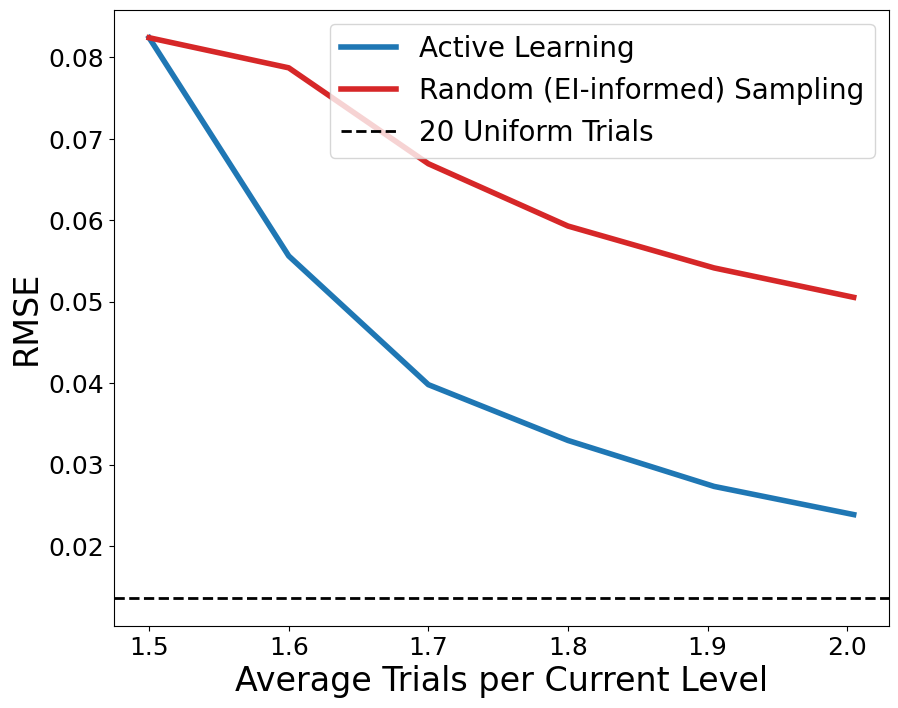

In [44]:
plt.figure(figsize=(10, 8))

plt.plot(np.array(num_samples)/trials_neg.shape[0]/trials_neg.shape[1], performances, linewidth=4, c='tab:blue', label='Active Learning')
plt.plot(np.array(num_samples_uniform)/trials_neg.shape[0]/trials_neg.shape[1], performances_uniform, linewidth=4, c='tab:red', label='Random (EI-informed) Sampling')

plt.axhline(performance_baseline, c='k', linestyle='--', linewidth=2, label=f'{baseline_trials} Uniform Trials')
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.xlabel('Average Trials per Current Level', fontsize=24)
plt.ylabel(r'RMSE', fontsize=24)
plt.legend(fontsize=20)

# plt.savefig(f'AL_{dataset}_single_elec_oldlv.png')

[[-19.07980205  -5.36198208]]
[[-16.23364217  -4.57764693]]


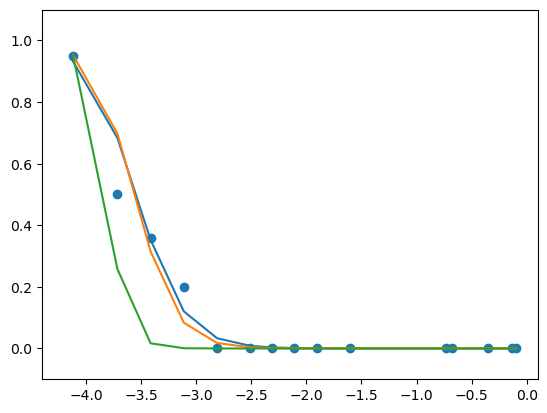

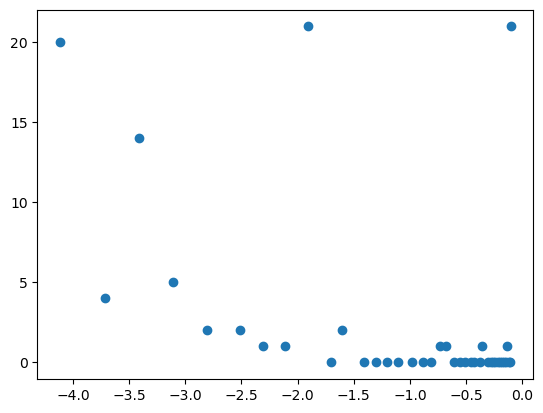

[[-7.89142259 -1.91141481]]
[[-5.94069615 -1.36055421]]


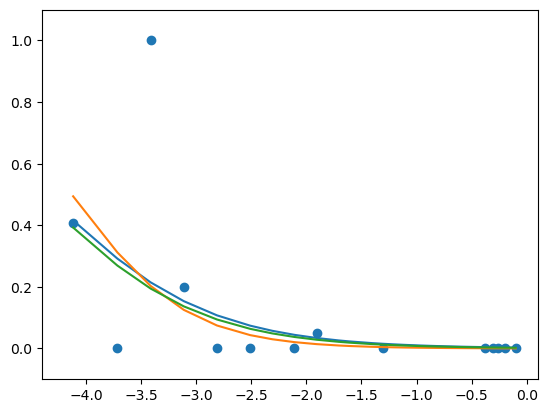

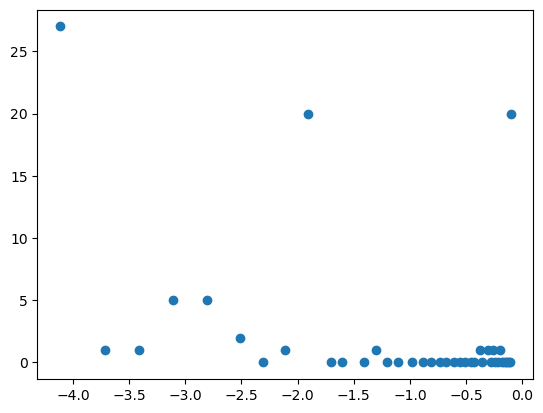

[[-8.02985961 -2.18467554]]
[[-8.38326547 -2.09541697]]


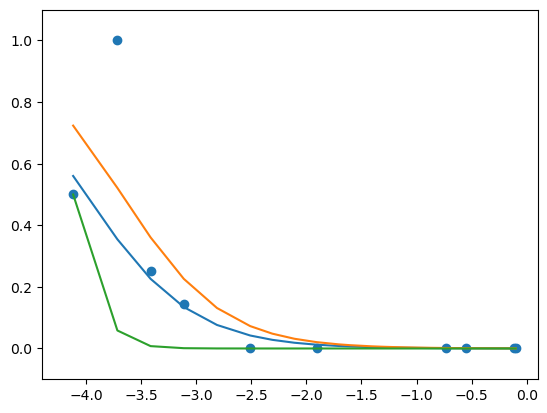

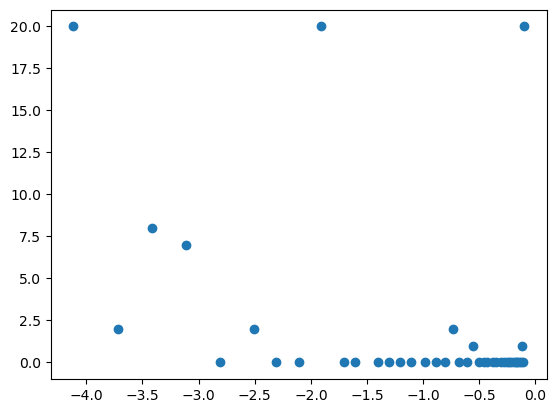

[[-8.36466675 -6.52887937]]
[[-10.92606089  -8.47061316]]


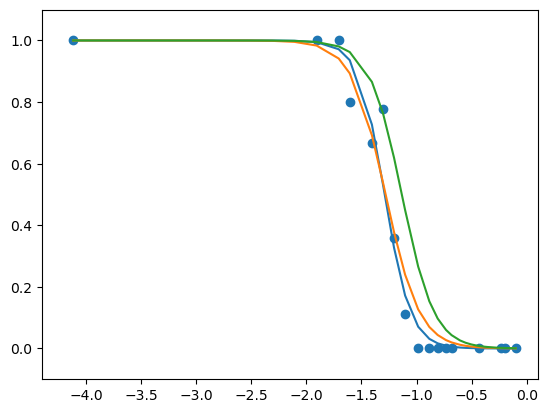

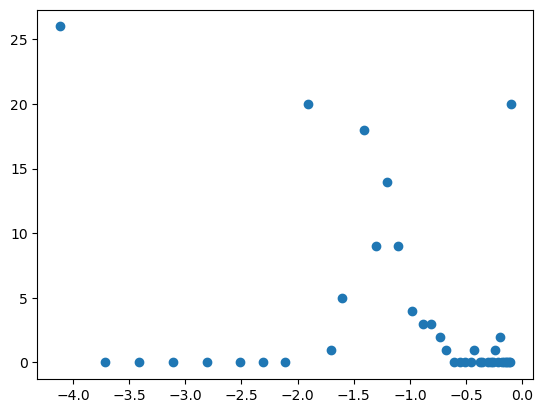

[[-8.81770815 -3.21865494]]
[[-11.08544282  -3.87621422]]


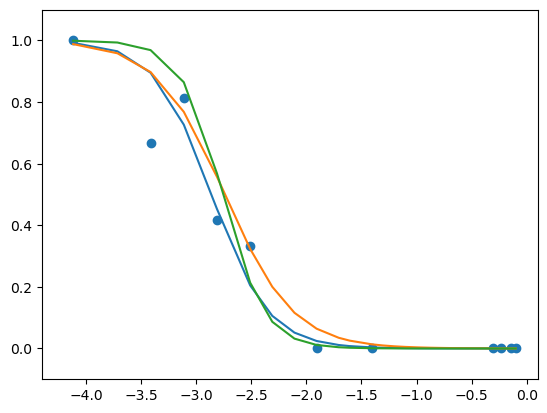

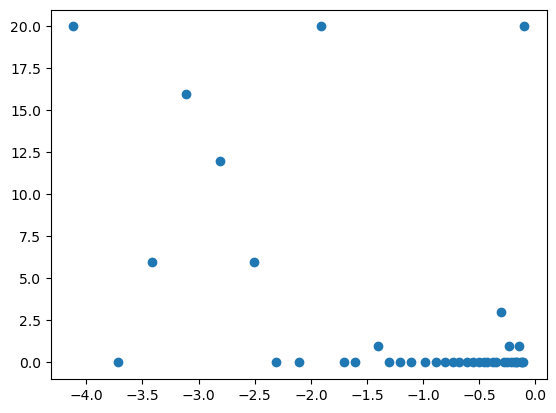

[[-7.35360999 -3.12160784]]
[[-5.87792816 -2.40433738]]


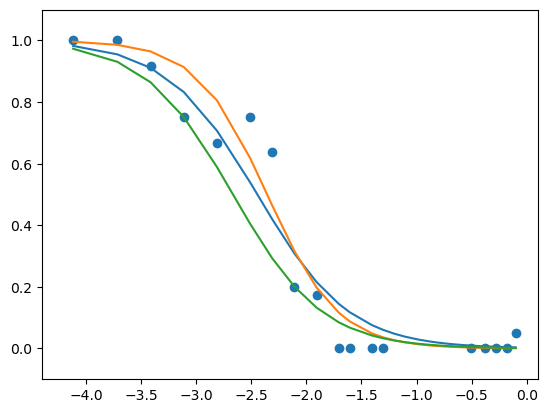

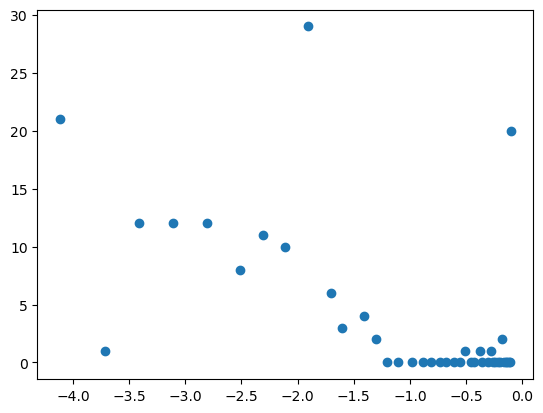

[[-8.15108004 -2.21120653]]
[[-5.73899973 -1.65094235]]


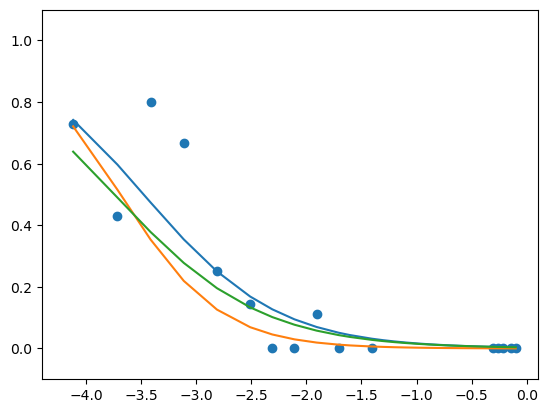

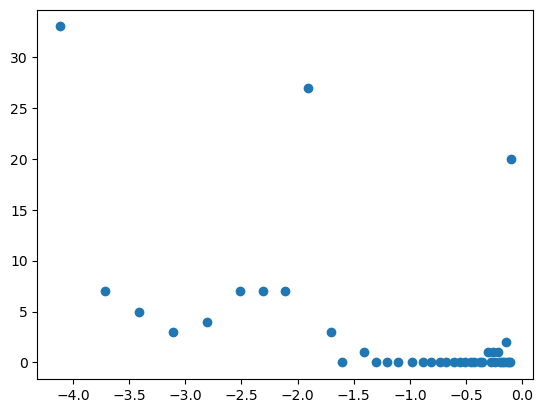

[[-7.29744576 -1.52626376]]
[[-42.26128666 -10.        ]]


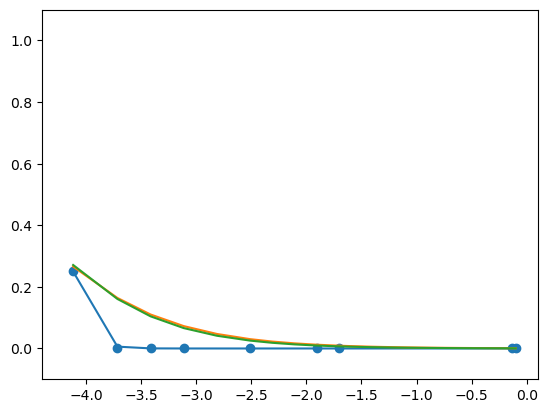

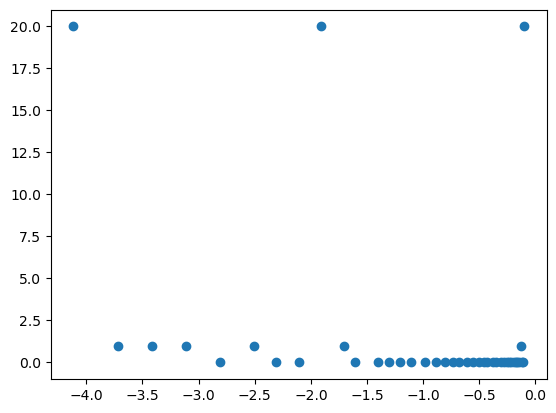

[[-5.64523684 -1.34175561]]
[[-6.79626746 -1.73332915]]


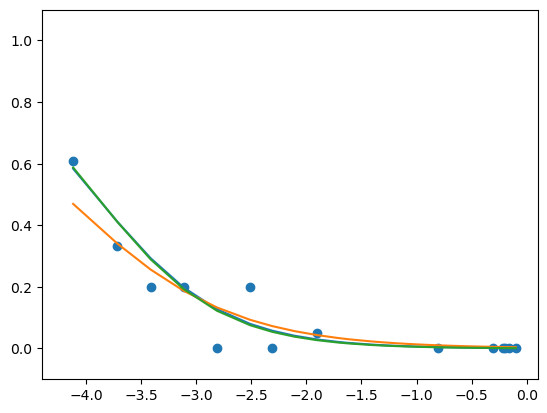

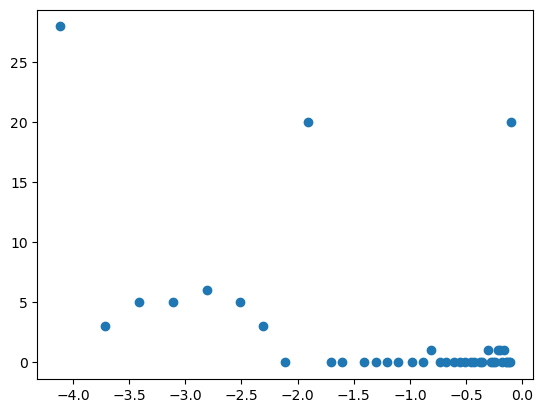

[[-6.85492462 -2.48322355]]
[[-5.26930227 -1.89952596]]


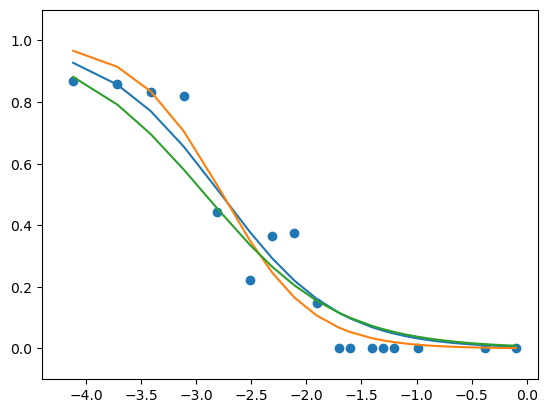

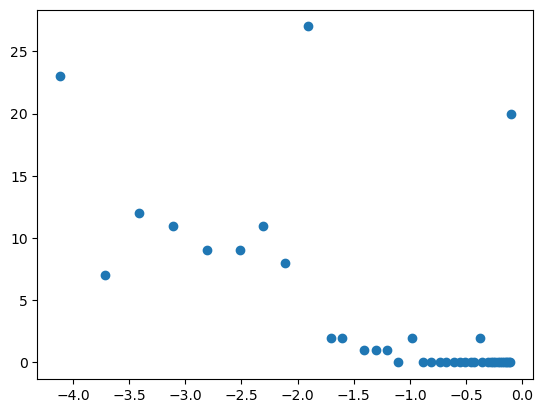

[[-7.63395313 -2.33184688]]
[[-8.70798275 -2.63279833]]


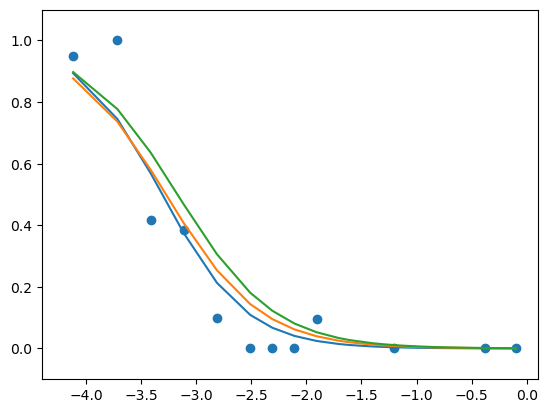

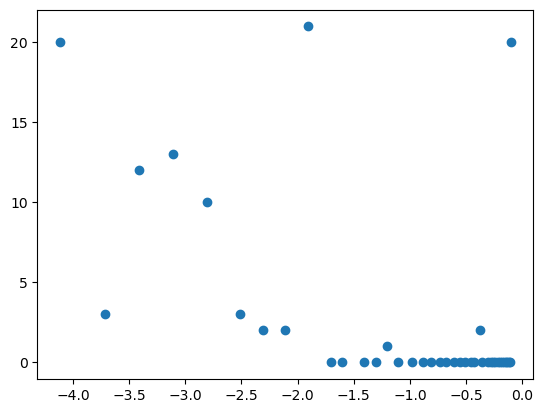

[[-6.98895473 -3.37863379]]
[[-7.02494722 -3.48342069]]


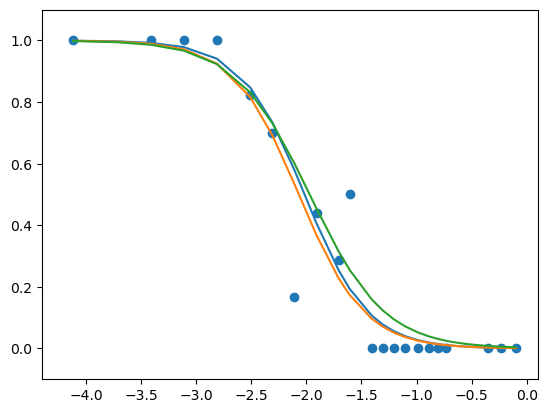

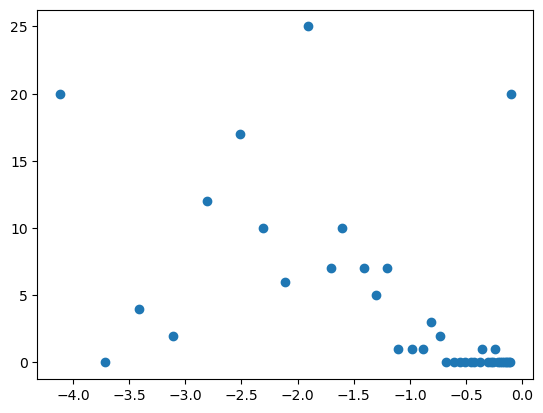

[[-9.86371098 -3.01543904]]
[[-14.59258147  -4.34285057]]


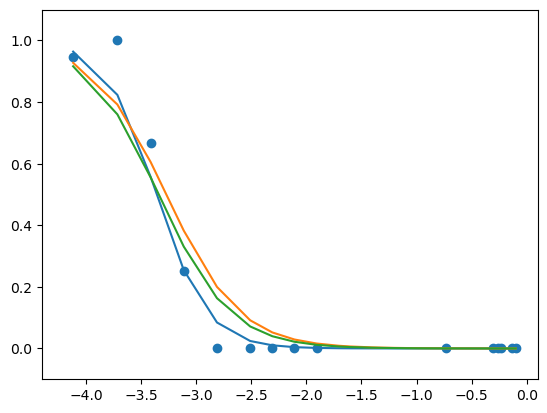

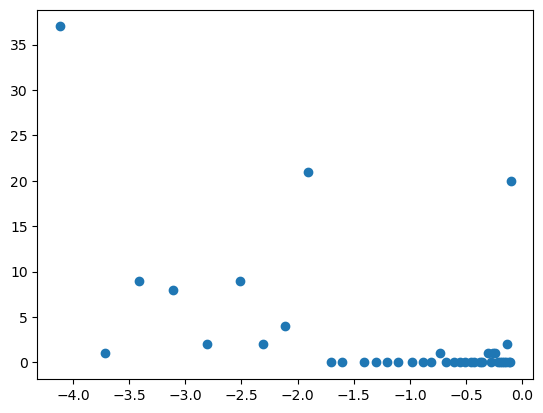

[[-9.35551664 -4.16484284]]
[[-12.30992032  -5.57591606]]


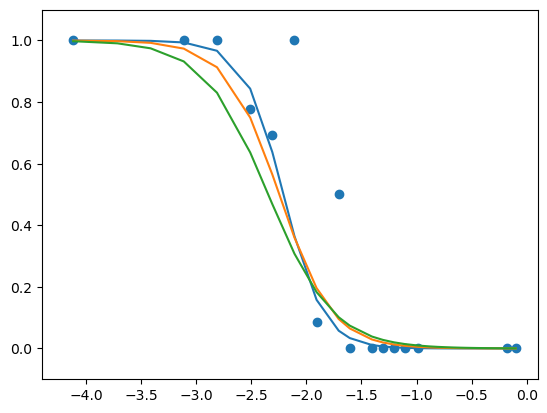

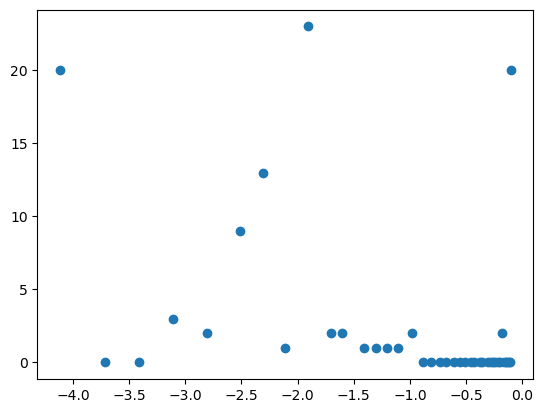

[[-23.80143295  -6.79673215]]
[[-35.54676769 -10.        ]]


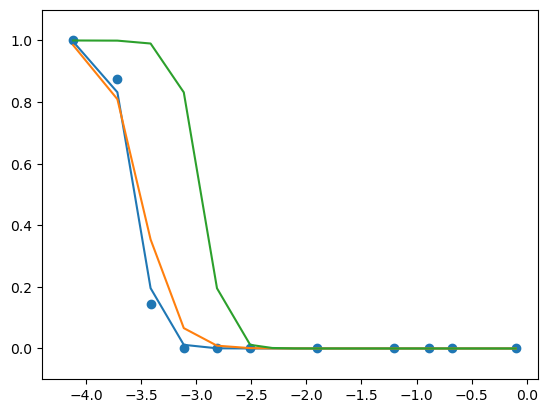

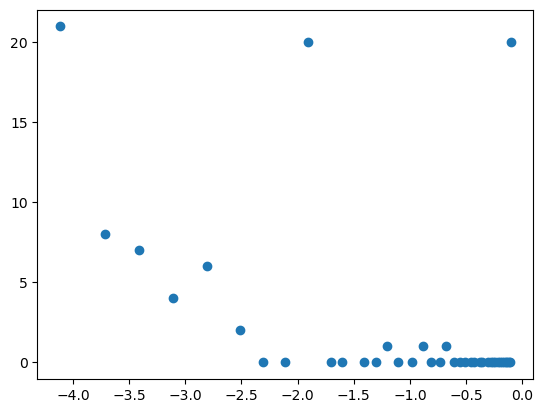

[[-6.41816687 -2.70417721]]
[[-5.42373657 -2.22792954]]


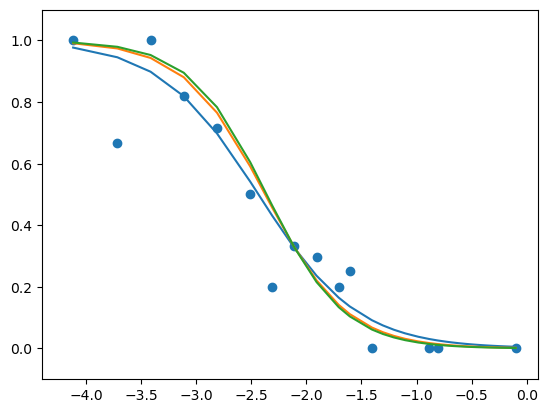

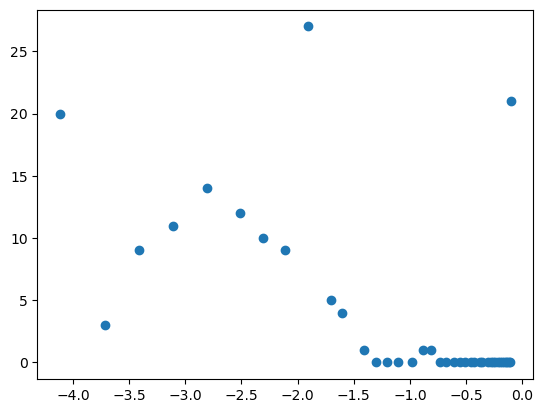

[[-9.22311306 -2.49912903]]
[[-8.55659885 -2.28819013]]


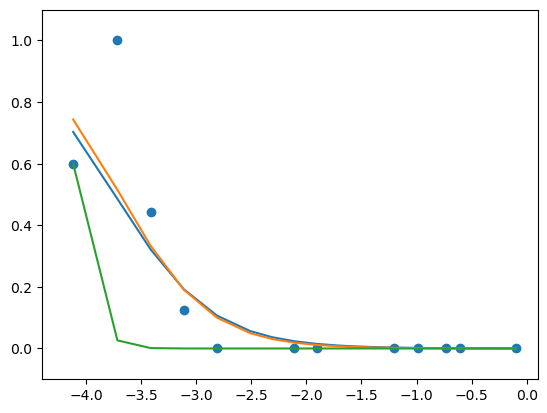

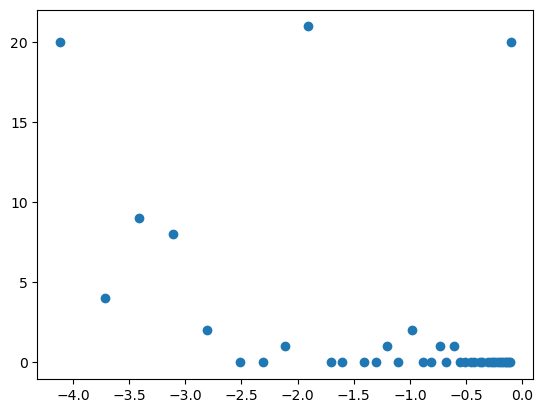

KeyboardInterrupt: Interrupted by user

In [45]:
# CHECK DATASET IF NEEDED

for i in range(len(probs_true)):
    for j in range(len(probs_true[i])):
        if ~np.all(params_true[i][j][:, 0] == -np.inf):

            sampled_inds = np.where(T_prev[j] > 0)[0]
            sampled_inds_uniform = np.where(T_prev_uniform[j] > 0)[0]

            print(params_true[i][j])
            print(params_curr[i][j])
            
            plt.figure(0)
            plt.xlim(-4.4, 0.1)
            plt.ylim(-0.1, 1.1)
            plt.scatter(amps_neg[j][sampled_inds], probs_empirical[i][j][sampled_inds])
            plt.plot(amps_neg[j], probs_curr[i][j])
            plt.plot(amps_neg[j], probs_true[i][j])
            plt.plot(amps_neg[j], probs_curr_uniform[i][j])

            plt.figure(1)
            plt.scatter(amps_neg[j], T_prev[j])

            plt.show()
            input()

In [ ]:
# CHECK DATASET IF NEEDED

for i in range(len(probs_true)):
    for j in range(len(probs_true[i])):
        if ~np.all(params_true[i][j][:, 0] == -np.inf):

            sampled_inds_uniform = np.where(T_prev_uniform[j] > 0)[0]

            print(params_true[i][j])
            
            plt.figure(0)
            plt.xlim(-4.4, 0.1)
            plt.ylim(-0.1, 1.1)
            plt.scatter(amps_neg[j][sampled_inds_uniform], probs_empirical_uniform[i][j][sampled_inds_uniform])
            plt.plot(amps_neg[j], probs_curr_uniform[i][j])
            plt.plot(amps_neg[j], probs_true[i][j])
            plt.show()
            input()

# New labview

In [ ]:
GSORT_BASE = "/Volumes/Scratch/Analysis"
ANALYSIS_BASE = "/Volumes/Analysis"
dataset = "2022-11-28-1"
wnoise = "data010"
prob_high = 1
prob_low = 0.2
min_inds = 2

estim_neg = "data009"

outpath = os.path.join(GSORT_BASE, dataset, estim_neg, wnoise)
electrical_path = os.path.join(ANALYSIS_BASE, dataset, estim_neg)
parameters = loadmat(os.path.join(outpath, 'parameters.mat'))

cells = parameters['cells'].flatten()
num_cells = len(cells)
num_patterns = max(parameters['patterns'].flatten())
num_movies = parameters['movies'].flatten()[0]

all_probs_neg = np.array(np.memmap(os.path.join(outpath, 'init_probs.dat'),mode='r',shape=(num_cells, num_patterns, num_movies), dtype='float32'))
trials_neg = np.array(np.memmap(os.path.join(outpath, 'trial.dat'),mode='r',shape=(num_patterns, num_movies), dtype='int16'), dtype=int)
amps_neg = np.array([mutils.get_stim_amps_newlv(electrical_path, 1).reshape(-1, 1)] * len(trials_neg))

for i in range(len(all_probs_neg)):
    for j in range(len(all_probs_neg[i])):
        if np.count_nonzero((all_probs_neg[i][j] >= prob_low) & (all_probs_neg[i][j] <= prob_high)) >= min_inds:
            print(cells[i], j+1)

            # all_probs[i][j] = fitting.disambiguate_fitting(amps[j], 
            #                                 all_probs[i][j],
            #                                 trials[j], [1], 
            #                                 prob_high=prob_high, prob_low=prob_low)

            all_probs_neg[i][j] = fitting.disambiguate_sigmoid(all_probs_neg[i][j], spont_limit=prob_low, noise_limit=0.1)
        
all_probs_neg = all_probs_neg[:, :, ::-1]
trials_neg = trials_neg[:, ::-1]
amps_neg = amps_neg[:, ::-1, :]

In [ ]:
all_probs_neg.shape

In [ ]:
estim_pos = "data003"

outpath = os.path.join(GSORT_BASE, dataset, estim_pos, wnoise)
electrical_path = os.path.join(ANALYSIS_BASE, dataset, estim_pos)
parameters = loadmat(os.path.join(outpath, 'parameters.mat'))

cells = parameters['cells'].flatten()
num_cells = len(cells)
num_patterns = max(parameters['patterns'].flatten())
num_movies = parameters['movies'].flatten()[0]

all_probs_pos = np.array(np.memmap(os.path.join(outpath, 'init_probs.dat'),mode='r',shape=(num_cells, num_patterns, num_movies), dtype='float32'))
trials_pos = np.array(np.memmap(os.path.join(outpath, 'trial.dat'),mode='r',shape=(num_patterns, num_movies), dtype='int16'), dtype=int)
amps_pos = np.array([mutils.get_stim_amps_newlv(electrical_path, 1).reshape(-1, 1)] * len(trials_pos))

# all_probs_pos[:, :, :blanked_probs] = np.zeros(all_probs_pos[:, :, :blanked_probs].shape)

for i in range(len(all_probs_pos)):
    for j in range(len(all_probs_pos[i])):
        all_probs_pos[i][j] = fitting.disambiguate_sigmoid(all_probs_pos[i][j], spont_limit=0.3, noise_limit=0.1)

In [ ]:
all_probs = all_probs_neg#np.concatenate((all_probs_neg, all_probs_pos), axis=2)
trials = trials_neg#np.concatenate((trials_neg, trials_pos), axis=1)
amps = amps_neg#np.concatenate((amps_neg, amps_pos), axis=1)

In [ ]:
ms = [1]

w_inits_array = np.zeros((all_probs.shape[0], all_probs.shape[1]), dtype=object)
for i in range(len(w_inits_array)):
    for j in range(len(w_inits_array[i])):
        w_inits = []

        for m in ms:
            w_init = np.array(np.random.normal(size=(m, amps[j].shape[1]+1)))
            w_inits.append(w_init)

        w_inits_array[i][j] = w_inits

In [ ]:
input_list = fitting.generate_input_list(all_probs, amps, trials, w_inits_array)

pool = mp.Pool(processes=24)
results = pool.starmap_async(fitting.fit_surface, input_list)
mp_output = results.get()
pool.close()

In [ ]:
params_true = np.zeros((all_probs.shape[0], all_probs.shape[1]), dtype=object)
inits = np.zeros((all_probs.shape[0], all_probs.shape[1]), dtype=object)
R2s = np.zeros((all_probs.shape[0], all_probs.shape[1]))
probs_true = np.zeros(all_probs.shape)

cnt = 0
for i in range(len(all_probs)):
    for j in range(len(all_probs[i])):
        params_true[i][j] = mp_output[cnt][0]
        inits[i][j] = mp_output[cnt][1]
        R2s[i][j] = mp_output[cnt][2]
        
        probs_true[i][j] = fitting.sigmoidND_nonlinear(
                                sm.add_constant(amps[j], has_constant='add'), 
                                params_true[i][j])
        

        cnt += 1

In [ ]:
# CHECK DATASET IF NEEDED

for i in range(len(all_probs)):
    for j in range(len(all_probs[i])):
        if ~np.all(params_true[i][j][:, 0] == -np.inf):
            print(cells[i], j+1)

            print(params_true[i][j], R2s[i][j])
            
            plt.figure(0)
            plt.xlim(-4.2, 0.1)
            plt.ylim(-0.1, 1.1)
            plt.scatter(amps[j].flatten(), all_probs[i][j])
            plt.plot(amps[j].flatten(), probs_true[i][j])
            plt.show()
            input()

In [ ]:
EI_cutoff = 0

vstim_datapath = os.path.join(ANALYSIS_BASE, dataset, wnoise)
vstim_datarun = wnoise[-7:]
vcd = vl.load_vision_data(vstim_datapath, vstim_datarun,
                          include_neurons=True,
                          include_ei=True,
                          include_params=True,
                          include_noise=True)

above_thr_inds = []
for n in vcd.get_cell_ids():
    cell_type = vcd.get_cell_type_for_cell(n).lower()
    if 'parasol' in cell_type or 'midget' in cell_type:
        _, EI = mutils.get_collapsed_ei_thr(vcd, n, 0)
        above_thr = np.where(EI > EI_cutoff)[0]
        if len(above_thr) > 0:
            above_thr_inds.append(above_thr)

above_thr_all = np.unique(np.concatenate(above_thr_inds))
bad_inds = np.setdiff1d(np.arange(len(trials), dtype=int), above_thr_all).astype(int)

In [ ]:
total_budget = 20000
num_iters = 2
budget = int(total_budget / num_iters)
reg = 20 # 50
T_step_size = 0.1 # 0.05, 0.01
T_n_steps = 2000    # 5000
init_trials = 5
ms = [1]
disambiguate = True
verbose = True
R2_cutoff = 0

T_prev = np.zeros_like(trials, dtype=float)
T_prev[:, ::4] = init_trials
T_prev[bad_inds, :] = 0
T_prev_uniform = deepcopy(T_prev)

probs_empirical = sample_spikes_array(probs_true, T_prev, NUM_THREADS=24)
probs_empirical_uniform = deepcopy(probs_empirical)

performances = []
performances_uniform = []
num_samples = []
num_samples_uniform = []

iter_cnt = 0
while True:
    # reg = reg * (0.8 ** (iter_cnt))  # UNTESTED
    if iter_cnt == 0:
        T_new, w_inits_array, t_final, probs_curr = fitting.fisher_sampling_1elec(probs_empirical, 
                                        T_prev, amps,
                                        T_step_size=T_step_size,
                                        T_n_steps=T_n_steps,
                                        verbose=verbose, budget=budget, ms=ms, reg=reg,
                                        return_probs=True,
                                        disambiguate=disambiguate,
                                        R2_cutoff=R2_cutoff)

        performance = get_performance_array(params_true, probs_curr, probs_true)
        performance_uniform = performance

        w_inits_array_uniform = deepcopy(w_inits_array)
        
    else:
        T_new, w_inits_array, t_final, probs_curr = fitting.fisher_sampling_1elec(probs_empirical, 
                                        T_prev, amps,
                                        T_step_size=T_step_size,
                                        T_n_steps=T_n_steps,
                                        verbose=verbose, budget=budget, ms=ms, reg=reg,
                                        return_probs=True,
                                        t_final=t_final,
                                        w_inits_array=w_inits_array,
                                        disambiguate=disambiguate,
                                        R2_cutoff=R2_cutoff)
        
        performance = get_performance_array(params_true, probs_curr, probs_true)

        input_list_uniform = fitting.generate_input_list(probs_empirical_uniform, amps, T_prev_uniform, w_inits_array_uniform,
                                                            disambiguate=disambiguate)

        pool = mp.Pool(processes=24)
        results_uniform = pool.starmap_async(fitting.fit_surface, input_list_uniform)
        mp_output_uniform = results_uniform.get()
        pool.close()

        params_curr_uniform = np.zeros((probs_empirical_uniform.shape[0], probs_empirical_uniform.shape[1]), dtype=object)
        w_inits_array_uniform = np.zeros((probs_empirical_uniform.shape[0], probs_empirical_uniform.shape[1]), dtype=object)
        probs_curr_uniform = np.zeros(probs_empirical_uniform.shape)

        cnt = 0
        for i in range(len(probs_empirical_uniform)):
            for j in range(len(probs_empirical_uniform[i])):
                params_curr_uniform[i][j] = mp_output_uniform[cnt][0]
                w_inits_array_uniform[i][j] = mp_output_uniform[cnt][1]
                
                probs_curr_uniform[i][j] = fitting.sigmoidND_nonlinear(
                                        sm.add_constant(amps[j], has_constant='add'), 
                                        params_curr_uniform[i][j])

                cnt += 1

        performance_uniform = get_performance_array(params_true, probs_curr_uniform, probs_true)
    
    print(performance, performance_uniform)
    
    performances.append(performance)
    performances_uniform.append(performance_uniform)
    
    num_samples.append(np.sum(T_prev))
    num_samples_uniform.append(np.sum(T_prev_uniform))

    iter_cnt += 1

    if iter_cnt > num_iters:
        break

    p_new = sample_spikes_array(probs_true, T_new, NUM_THREADS=24)
    p_tmp = (p_new * T_new[np.newaxis, :, :] + probs_empirical * T_prev[np.newaxis, :, :]) / ((T_new + T_prev)[np.newaxis, :, :])
    T_tmp = T_new + T_prev

    p_tmp = np.nan_to_num(p_tmp, nan=0.5)

    probs_empirical = p_tmp
    T_prev = T_tmp
    
    T_new_uniform = np.ones_like(T_prev_uniform, dtype=float)
    T_new_uniform[bad_inds, :] = 0
    p_new_uniform = sample_spikes_array(probs_true, T_new_uniform, NUM_THREADS=24)

    p_tmp_uniform = (p_new_uniform * T_new_uniform[np.newaxis, :, :] + probs_empirical_uniform * T_prev_uniform[np.newaxis, :, :]) / ((T_prev_uniform + T_new_uniform)[np.newaxis, :, :])
    T_tmp_uniform = T_prev_uniform + T_new_uniform

    p_tmp_uniform = np.nan_to_num(p_tmp_uniform, nan=0.5)

    probs_empirical_uniform = p_tmp_uniform
    T_prev_uniform = T_tmp_uniform

In [ ]:
baseline_trials = 20
T_prev_baseline = np.ones_like(trials, dtype=float) * baseline_trials

probs_empirical_baseline = sample_spikes_array(probs_true, T_prev_baseline, NUM_THREADS=24)

w_inits_array_baseline = np.zeros((probs_empirical_baseline.shape[0], probs_empirical_baseline.shape[1]), dtype=object)
for i in range(len(w_inits_array_baseline)):
    for j in range(len(w_inits_array_baseline[i])):
        w_inits = []

        for m in ms:
            w_init = np.array(np.random.normal(size=(m, amps[j].shape[1]+1)))
            w_inits.append(w_init)

        w_inits_array_baseline[i][j] = w_inits

input_list_baseline = fitting.generate_input_list(probs_empirical_baseline, amps, T_prev_baseline, w_inits_array_baseline,
                                                    disambiguate=disambiguate)

pool = mp.Pool(processes=24)
results_baseline = pool.starmap_async(fitting.fit_surface, input_list_baseline)
mp_output_baseline = results_baseline.get()
pool.close()

params_curr_baseline = np.zeros((probs_empirical_baseline.shape[0], probs_empirical_baseline.shape[1]), dtype=object)
w_inits_array_baseline = np.zeros((probs_empirical_baseline.shape[0], probs_empirical_baseline.shape[1]), dtype=object)
probs_curr_baseline = np.zeros(probs_empirical_baseline.shape)

cnt = 0
for i in range(len(probs_empirical_baseline)):
    for j in range(len(probs_empirical_baseline[i])):
        params_curr_baseline[i][j] = mp_output_baseline[cnt][0]
        w_inits_array_baseline[i][j] = mp_output_baseline[cnt][1]
        
        probs_curr_baseline[i][j] = fitting.sigmoidND_nonlinear(
                                sm.add_constant(amps[j], has_constant='add'), 
                                params_curr_baseline[i][j])

        cnt += 1

performance_baseline = get_performance_array(params_true, probs_curr_baseline, probs_true)

In [ ]:
plt.figure(figsize=(10, 8))

plt.plot(np.array(num_samples)/trials.shape[0]/trials.shape[1], performances, linewidth=4, c='tab:blue', label='Active Learning')
plt.plot(np.array(num_samples_uniform)/trials.shape[0]/trials.shape[1], performances_uniform, linewidth=4, c='tab:red', label='Uniform Sampling')

plt.axhline(performance_baseline, c='k', linestyle='--', linewidth=2, label='20 Uniform Trials')
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.xlabel('Average Trials per Current Level', fontsize=24)
plt.ylabel(r'RMSE', fontsize=24)
plt.legend(fontsize=20)

In [ ]:
# CHECK DATASET IF NEEDED

for i in range(len(probs_true)):
    for j in range(len(probs_true[i])):
        if ~np.all(params_true[i][j][:, 0] == -np.inf):

            sampled_inds = np.where(T_prev[j] > 0)[0]

            print(params_true[i][j])
            
            plt.figure(0)
            plt.xlim(-4.4, 4.4)
            plt.ylim(-0.1, 1.1)
            plt.scatter(amps[j][sampled_inds], probs_empirical[i][j][sampled_inds])
            plt.plot(amps[j], probs_curr[i][j])
            plt.plot(amps[j], probs_true[i][j])
            plt.show()
            input()

In [ ]:
amps[1][10:]